In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import halfspace.projections as hsp
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
stress_file = '../../nepal_2015/stress_arrays/nepal_topo_stress.h5'

sdb = h5py.File(stress_file, 'r')

In [4]:
sdb['xx_MPa'].shape, np.product(sdb['xx_MPa'].shape)

((1603, 2818, 51), 230379954)

In [5]:
with open('../../nepal_2015/stress_arrays/stress_calcs_meta.json') as f:
    s_meta = json.load(f)

In [6]:
s_meta

{'b_conv_mode': 'valid', 'c_conv_mode': 'same', 'z_max': 30000, 'z_res': 500}

In [7]:
z_len = sdb['xx_MPa'].shape[2]

z_vec = np.linspace(s_meta['z_res'], s_meta['z_max'], z_len)

In [8]:
z_vec

array([   500.,   1090.,   1680.,   2270.,   2860.,   3450.,   4040.,
         4630.,   5220.,   5810.,   6400.,   6990.,   7580.,   8170.,
         8760.,   9350.,   9940.,  10530.,  11120.,  11710.,  12300.,
        12890.,  13480.,  14070.,  14660.,  15250.,  15840.,  16430.,
        17020.,  17610.,  18200.,  18790.,  19380.,  19970.,  20560.,
        21150.,  21740.,  22330.,  22920.,  23510.,  24100.,  24690.,
        25280.,  25870.,  26460.,  27050.,  27640.,  28230.,  28820.,
        29410.,  30000.])

In [128]:
depth_ind = 6
depth = z_vec[depth_ind]
depth

4040.0

In [129]:
xx_stress = sdb['xx_MPa'][:,:,depth_ind]
yy_stress = sdb['yy_MPa'][:,:,depth_ind]
zz_stress = sdb['zz_MPa'][:,:,depth_ind]
xy_stress = sdb['xy_MPa'][:,:,depth_ind]
xz_stress = sdb['xz_MPa'][:,:,depth_ind]
yz_stress = sdb['yz_MPa'][:,:,depth_ind]

In [130]:
T = pd.read_csv('../results/T_best.csv', index_col=0, header=None, squeeze=True)
T

0
txx    0.096860
txy   -0.199583
tyy    0.050988
Name: 1, dtype: float64

In [168]:
rg = 9.81 * 2700 / 1e6

rgz = rg *depth #* 0
#txx, tyy, txy = T.txx * rgz, T.tyy * rgz, T.txy * rgz

txx, tyy, txy = 0.033 * rgz, 0.467 * rgz, 0.125 * rgz # experimental

txx, tyy, txy

(0.0, 0.0, 0.0)

In [169]:
rgz

0.0

In [170]:
nrows, ncols = xx_stress.shape

In [171]:
sd = {'xx': xx_stress + txx,
      'yy': yy_stress + tyy,
      'zz': zz_stress,
      'xy': xy_stress + txy,
      'xz': xz_stress,
      'yz': yz_stress}

In [172]:
def deform_style(T, P):
    
    return P.plunge - T.plunge
    
    
def deform_style_from_tensor(S):
    T, N, P = hsp.get_princ_axes_xyz(S)
    
    return deform_style(T, P)


def make_S(sd, i, j):
    
    return hsp.make_xyz_stress_tensor(sig_xx=sd['xx'][i,j],
                                      sig_yy=sd['yy'][i,j],
                                      sig_zz=sd['zz'][i,j],
                                      sig_xy=sd['xy'][i,j],
                                      sig_xz=sd['xz'][i,j],
                                      sig_yz=sd['yz'][i,j])

def def_style_from_ij(sd, i,j):
    
    S = make_S(sd, i, j)
    
    return deform_style_from_tensor(S)

In [173]:
S_test = hsp.make_xyz_stress_tensor(sig_xx=100, sig_yy=35, sig_zz = 20)

deform_style_from_tensor(S_test)

-90.0

In [174]:
n_skip = 5

def_styles = [def_style_from_ij(sd, i, j) for i in range(nrows)[::n_skip] 
                                              for j in range(ncols)[::n_skip]]

In [175]:
def_styles = np.array(def_styles)

In [176]:
def_styles.shape

(181044,)

In [177]:
def_styles_ = np.copy(def_styles)

In [178]:
def_styles = def_styles.reshape((len(range(nrows)[::n_skip]), 
                                 len(range(ncols)[::n_skip])))

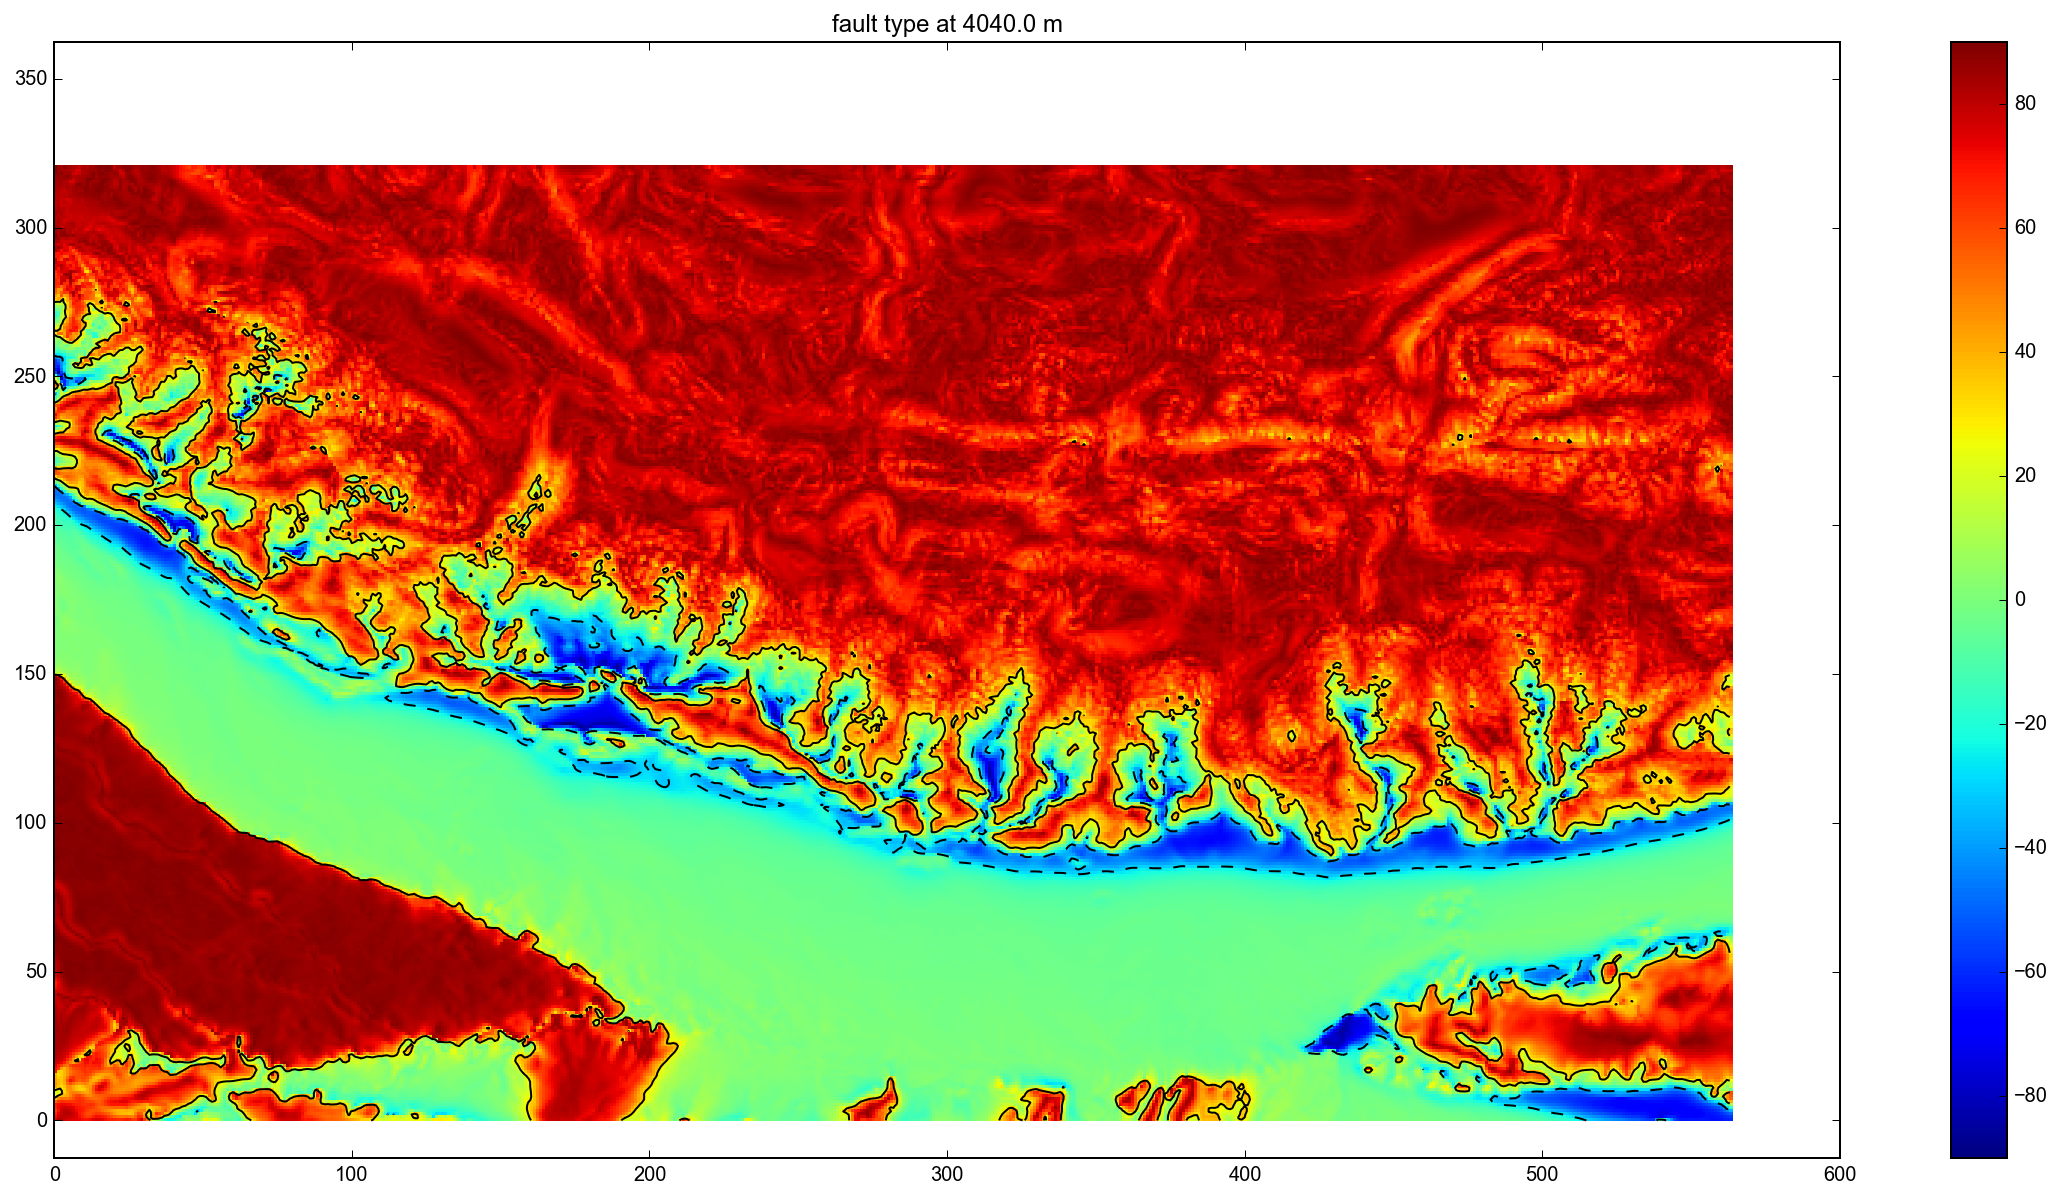

In [179]:
plt.figure(figsize=(20,10))

plt.pcolormesh(def_styles, vmax=90, vmin=-90)
plt.colorbar()
plt.contour(def_styles, [30, -30], colors='k', lw=0.25)
plt.axis('equal')
plt.title('fault type at {} m'.format(depth))